## Reading in packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from numpy import asarray
from numpy import savetxt
import matplotlib.colors as mcolors
import matplotlib.cm
import matplotlib.patches as mpatches
import umap
import matplotlib as mpl
import scanpy as sc
import scipy
import kmapper as km
from kmapper import jupyter
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
import plotly.graph_objs as go
import sys
from sklearn import ensemble
import tqdm
from ripser import Rips
from sklearn.metrics.pairwise import euclidean_distances

## Read in data

Select either the whole sc transformed dataset or just the variable genes

In [2]:
ILC_var = sc.read("sct_variable.h5ad")
ILC = sc.read("sct.h5ad")

c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
PCA_coord = ILC_var.obsm["X_pca"]
Diff_coord = ILC_var.obsm["X_diffmap"]

In [4]:
#norm_reads_sparse = ILC_var.layers["norm_data"]
norm_reads_sparse = ILC.layers["norm_data"]
norm_reads = pd.DataFrame(norm_reads_sparse.toarray())
print("Norm reads: "+repr(norm_reads.shape))

UMAP = ILC_var.obsm["umap_cell_embeddings"]
Diff = ILC_var.obsm['X_draw_graph_fa']

Norm reads: (26877, 15806)


## Selecting all ILC2 and ILC3 cells

### Run if writing csv files

In [5]:
Variable = ILC_var.var

Obs = ILC_var.obs
O = Obs["ilc2_ilc3"].to_frame()

Variable["Selected"].to_csv('Gene_list_ILC.csv', sep=',')
O.to_csv('Cell_list_ILC.csv', sep=',')

### Run if reading csv files

In [6]:
Gene_list = pd.read_csv("Gene_list_ILC.csv", sep=",", header = 0)
Gene_list = np.array(Gene_list)
Gene_list = Gene_list[:,0]
Cell_list = pd.read_csv("Cell_list_ILC.csv", sep=",", header = 0)
Cell_list = np.array(Cell_list)
Cell_list = Cell_list[:,0]

print("Gene list:"+repr(Gene_list))
print("Cell list:"+repr(Cell_list))

Gene list:array(['Yfp', 'Rb1cc1', 'Mcmdc2', ..., 'mt-Cytb', 'AC149090.1',
       'Cre (Il5)'], dtype=object)
Cell list:array(['Timept0.AAACCCAAGCTATCTG', 'Timept0.AAACCCAAGGTAATCA',
       'Timept0.AAACCCAAGTCTAACC', ..., 'Timept4.TTTGTTGCATCCAATG',
       'Timept4.TTTGTTGTCATTCATC', 'Timept4.TTTGTTGTCGCACTCT'],
      dtype=object)


## Collecting cells of interest

In this model of psoriasis, tissue resident ILC2s are reprogramed to ILC3s. 

For analysis we are selecting for cells likely to be ILC2s or ILC3s on the basis of previously characterized populations.

In [7]:
#Full matrix of all counts
matrix = ILC_var.layers["norm_data"]
matrix = np.array(matrix.toarray())

ILC_total_reads = pd.DataFrame(matrix, index = Cell_list, columns = Gene_list)
print(ILC_total_reads.shape)

(26877, 3000)


In [8]:
#We have four labeled groups of cells that we want to collect together
ILC2_ILC3 = ILC_var.obs["ilc2_ilc3"]
ILC3_Q = ILC_var.obs["quiescent_ilc3"]
ILC2_Q = ILC_var.obs["ilc2_quiescent"]
cloud_ILC3 = ILC_var.obs["cloud_ilc3"]

df = pd.DataFrame(dict(ILC2_ILC3 = ILC2_ILC3, ILC3_Q = ILC3_Q, ILC2_Q = ILC2_Q, cloud_ILC3 = cloud_ILC3))
cells = df.shape[0]

In [9]:
#binary yes ir no for if the cell is in our group
in_transition = np.zeros((cells, 1))

#Value of group - 0 if NA - over all cells
allcell_ILC2_ILC3 = np.zeros((cells, 1))
allcell_ILC3_Q = np.zeros((cells, 1))
allcell_ILC2_Q = np.zeros((cells, 1))
allcell_cloud_ILC3 = np.zeros((cells, 1))

#Cell labels - 0 if NA in all groups - over all cells
index_cells = np.zeros((cells, 1))
index_cells = index_cells.astype(str)

#Value of group - only cells in at least one group
val_ILC2_ILC3 = np.zeros((3807, 1))
val_ILC3_Q = np.zeros((3807, 1))
val_ILC2_Q = np.zeros((3807, 1))
val_cloud_ILC3 = np.zeros((3807, 1))

#Names of cells included in the value variables
index_val = np.array([])

#Variable for initially counting the number of cells in the groups of interest
number = 0


#Loops through the different groups so that we collect all cells with a value in at least one of the groups
for i in range(0,cells):
    if np.isnan(df["ILC2_ILC3"][i]):

        if np.isnan(df["ILC3_Q"][i]):

            if np.isnan(df["ILC2_Q"][i]):

                if np.isnan(df["cloud_ILC3"][i]):

                    in_transition[i,0] = 0
                    
                    allcell_ILC2_ILC3[i,0] = 0
                    allcell_ILC3_Q[i,0] = 0
                    allcell_ILC2_Q[i,0] = 0
                    allcell_cloud_ILC3[i,0] = 0
                    
                    index_cells[i,0] = "0"
                    
                else:
                    in_transition[i,0] = 1
                    
                    allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
                    allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
                    allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
                    allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
                    
                    index_cells[i,0] = Cell_list[i]
                    
                    val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
                    val_ILC3_Q[number] = df["ILC3_Q"][i]
                    val_ILC2_Q[number] = df["ILC2_Q"][i]
                    val_cloud_ILC3[number] = df["cloud_ILC3"][i]
                    
                    index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
                    
                    number += 1
            else:
                in_transition[i,0] = 1
                
                allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
                allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
                allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
                allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
                
                index_cells[i,0] = Cell_list[i]
                
                val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
                val_ILC3_Q[number] = df["ILC3_Q"][i]
                val_ILC2_Q[number] = df["ILC2_Q"][i]
                val_cloud_ILC3[number] = df["cloud_ILC3"][i]
                
                index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
                
                number += 1             

        else:
            in_transition[i,0] = 1
            
            allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
            allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
            allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
            allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
            
            index_cells[i,0] = Cell_list[i]
            
            val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
            val_ILC3_Q[number] = df["ILC3_Q"][i]
            val_ILC2_Q[number] = df["ILC2_Q"][i]
            val_cloud_ILC3[number] = df["cloud_ILC3"][i]
            
            index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
            
            number += 1
    
    else:
        in_transition[i,0] = 1
        
        allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
        allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
        allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
        allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
        
        index_cells[i,0] = Cell_list[i]
        
        val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
        val_ILC3_Q[number] = df["ILC3_Q"][i]
        val_ILC2_Q[number] = df["ILC2_Q"][i]
        val_cloud_ILC3[number] = df["cloud_ILC3"][i]
        
        index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
        
        number += 1
      

print(number)

3807


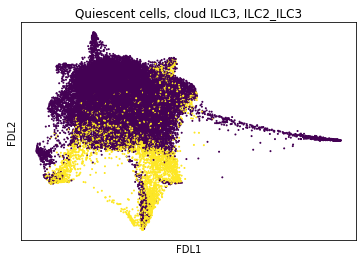

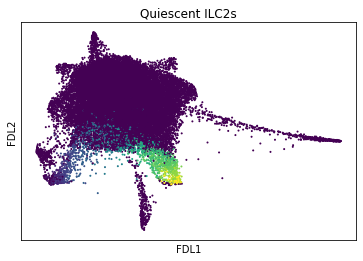

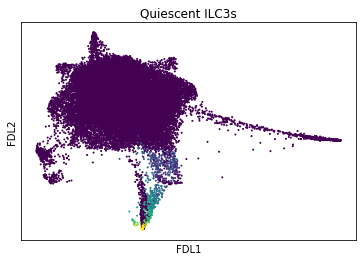

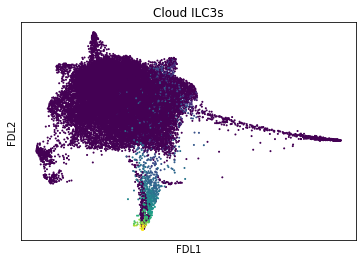

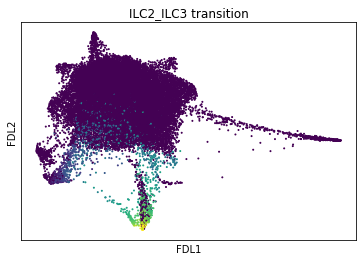

In [10]:
#There are some nan values in these arrays that we want to force to zero
val_ILC2_ILC3[np.isnan(val_ILC2_ILC3)] = 0
val_ILC3_Q[np.isnan(val_ILC3_Q)] = 0
val_ILC2_Q[np.isnan(val_ILC2_Q)] = 0
val_cloud_ILC3[np.isnan(val_cloud_ILC3)] = 0  

frame1 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = in_transition)
plt.title('Quiescent cells, cloud ILC3, ILC2_ILC3')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame2 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_ILC2_Q)
plt.title('Quiescent ILC2s')
#plt.xlim(-30000,25000)
frame2.axes.get_xaxis().set_ticks([])
frame2.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame3 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_ILC3_Q)
plt.title('Quiescent ILC3s')
frame3.axes.get_xaxis().set_ticks([])
frame3.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame4 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_cloud_ILC3)
plt.title('Cloud ILC3s')
frame4.axes.get_xaxis().set_ticks([])
frame4.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame5 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_ILC2_ILC3)
plt.title('ILC2_ILC3 transition')
frame5.axes.get_xaxis().set_ticks([])
frame5.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

### Creating normalized read matrix for only the cells of interest

In [ ]:
#Numpy array with normalized reads for all cells
norm_reads = np.array(norm_reads)
print(norm_reads.shape)
PCA_coord = np.array(PCA_coord)
print(PCA_coord.shape)
Diff_coord = np.array(Diff_coord)
print(Diff_coord.shape)

#Number of genes to initialize new matrix
genes = Gene_list.shape[0]
reads = np.zeros((1,15806 ))

PCA_reads = np.zeros((1,50))
Diff_reads = np.zeros((1,15))

#Going through all of the cells, if the  associated index in index_cell is nonzero then 
#it was included in our group and we should pull the associated gene expression data
for i in range(0,cells):
    j = index_cells[i]
    if j != "0":
        next_cell = norm_reads[i,:]
        next_cell = np.reshape(next_cell, (1,15806 ))
        reads = np.append(reads, next_cell, axis = 0)
        
        next_PCA = PCA_coord[i,:]
        next_PCA = np.reshape(next_PCA, (1,50))
        PCA_reads = np.append(PCA_reads, next_PCA, axis = 0)
        
        next_Diff = Diff_coord[i,:]
        next_Diff = np.reshape(next_Diff, (1,15))
        Diff_reads = np.append(Diff_reads, next_Diff, axis = 0)

#To get the indices to work out I have a row of zeros at the top that I need to omit
reads = reads[1:, :]    
PCA_reads = PCA_reads[1:, :]
Diff_reads = Diff_reads[1:, :]

(26877, 15806)
(26877, 50)
(26877, 15)


# Save or read in matrix with cells of interest

In [ ]:
np.savetxt("ILCs_reads.csv", reads, delimiter=',')
np.savetxt("ILCs_index.csv", index_val, delimiter=',', fmt="%s")
np.savetxt("index_cells.csv", index_cells, delimiter=',', fmt="%s")

In [ ]:
ILCs_reads = pd.read_csv("ILCs_reads.csv", sep=",", header = None) #Normalized gene expression of cells of interest
ILCs_reads_values = np.array(ILCs_reads)

ILCs_index = pd.read_csv("ILCs_index.csv", sep=",", header = None)

## Distance Matrix

In [ ]:
from manifold_utils.mSVD import eigen_plot, eigen_calc_from_dist_mat, eps_projection

In [ ]:
np_data = np.array(ILC_total_reads)
N, d = np_data.shape
dist_mat = euclidean_distances(np_data, np_data)

In [ ]:
#dist_mat = np.zeros((N, N))

#for j in range(N):
#    for k in range(0,N):
#        if j != k:
#            dist_mat[j, k] = np.linalg.norm(np_data[j, :] - np_data[k, :])
            
            
#    if j % 1000 == 0:
#        print("J: "+repr(j))
#        print("N: "+repr(N))

In [ ]:
#savetxt('dist_mat_ILC.csv', dist_mat, delimiter=',')

#dist_mat = pd.read_csv('dist_mat_ILC.csv', sep=",", header = None)
#dist_mat = np.array(dist_mat )

In [ ]:
print(dist_mat.shape)

## Witness complex

In [ ]:
from time import time
import numpy as np
from tda_utils.density_filtration import sort_distances_per_point, indices_for_density_filtration
from tda_utils.witness_complex import *

dist_per_pt = sort_distances_per_point(dist_mat)

# Load in ILC data
sct_sparse = np_data
dist_mat = dist_mat
n, d = sct_sparse.shape
print("n = "+str(n))
print("d = "+str(d))
print("shape of dist_mat: "+str(dist_mat.shape))

# Load in distances per point
distances_per_point = dist_per_pt

# time computation of density filtrations
print("Timing computation of density filtrations...")
density_indices = dict()
density_filtrations = dict()
ks = [10, 100, 1000]
#      10000]
ps = [0.01, 0.05, 0.1, 0.2]
for k in ks:
    for p in ps:
        print("\tk = "+str(k)+", p = "+str(p)+":")
        start = time()
        indices = indices_for_density_filtration(distances_per_point, k, p)
        density_indices[(k, p)] = indices
        mask = np.zeros(n, dtype=bool)
        mask[indices] = True
        sqr_mask = np.outer(mask, mask)
        density_filtrations[(k, p)] = np.reshape(dist_mat[sqr_mask], (len(indices), len(indices)))
        print("\t"+str(time()-start)+" seconds\n")

print("Timing computation of landmarks...")
landmark_indices = dict()
landmark_mats = dict()
pps = [0.05, 0.1, 0.2]
for k in ks:
    for p in ps:
        for pp in pps:
            print("\tk = "+str(k)+", p = "+str(p)+", pp = "+str(pp)+":")
            start = time()
            landmark_indices[(k, p, pp)], landmark_mats[(k, p, pp)] = choose_landmarks(density_filtrations[(k, p)], pp)
            print("\t"+str(time()-start)+" seconds\n")

print("Printing numbers of landmarks...")
for k in ks:
    for p in ps:
        for pp in pps:
            toople = (k, p, pp)
            print(str(toople)+": "+str(len(landmark_indices[toople])))
            if toople == (1000, 0.2, 0.2):
                print("saving")
                landmark_inds = landmark_indices[toople]
                dense_inds = density_indices[(k, p)]
                true_inds = [dense_inds[ind] for ind in landmark_inds]
                print(true_inds)
                to_save = np.vstack([sct_sparse[ind, :] for ind in true_inds])
                np.save("ILC_landmarks.npy", to_save)
                np.save("ILC_landmark_indices.npy", true_inds)

## Visualize Landmarks

In [ ]:
landmarks = np.load("ILC_landmarks.npy")

landmarks = true_inds
print(true_inds)

In [ ]:
N, d = np_data.shape

UMAP = np.array(UMAP)
print(UMAP.shape)

UMAP_landmark = np.zeros((1,2))
data_landmark = np.zeros((1,d))

#Going through all of the cells, if index in landmarks we should pull the associated gene expression data
for i in landmarks:
    next_cell = np_data[i,:]
    next_cell = np.reshape(next_cell, (1, d))
    data_landmark = np.append(data_landmark, next_cell, axis = 0)
        
    next_embedding = UMAP[i,:]
    next_embedding = np.reshape(next_embedding, (1,2))
    UMAP_landmark = np.append(UMAP_landmark, next_embedding, axis = 0)

#To get the indices to work out I have a row of zeros at the top that I need to omit
data_landmark = data_landmark[1:, :]    
UMAP_landmark = UMAP_landmark[1:, :]

print(data_landmark.shape)
print(UMAP_landmark.shape)

In [ ]:
frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=1, c = "silver")
frame1 = plt.scatter(UMAP_landmark[:,0], UMAP_landmark[:,1], s=1, c = "red")
plt.title('Racute - UMAP')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

## Persistence Diagrams

In [ ]:
#rips = Rips()
#diagrams = rips.fit_transform(np_data, distance_matrix=False, metric="euclidean")
#rips.plot(diagrams)

In [ ]:
rips = Rips()
diagrams = rips.fit_transform(data_landmark, distance_matrix=False, metric="euclidean")
rips.plot(diagrams)

## Eigen plots

In [ ]:
from manifold_utils.mSVD import eigen_plot, eigen_calc_from_dist_mat, eps_projection, eigen_plot_numPoints, eigen_calc_from_dist_mat_withNumPoints
from manifold_utils.iga import chakraborty_express, iga

In [ ]:
#for i in range(len(landmarks)):
#    print(landmarks[i])
#    center = landmarks[i]
#    radii, eigval_list, eigvec_list = eigen_calc_from_dist_mat(np_data, dist_mat, center, radint = .01)

#    rmin = radii[0]
#    rmax = radii[-1]
    
#    eigen_plot(eigval_list, radii, rmin, rmax)

In [ ]:
radius = 20

for i in range(len(landmarks)):
    print(landmarks[i])
    center = landmarks[i]
    radii, eigval_list, eigvec_list = eigen_calc_from_dist_mat(np_data, dist_mat, center, radint = 1)

    rmin = radii[0]
    rmax = radii[-1]
    
    eigen_plot(eigval_list, radii, rmin, rmax)
      
    landmark_loc = UMAP[center,:]
    radius_UMAP = np.zeros((1,2))
    for j in range(dist_mat.shape[0]):
        if j > center:
            if dist_mat[center,j] < radius:
                radius_UMAP = np.append(radius_UMAP, np.reshape(UMAP[j,:], (1,2)), axis = 0)
    radius_UMAP = radius_UMAP[1:,:]
    
    frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=1, c = "lightgrey")
    frame1 = plt.scatter(radius_UMAP[:,0], radius_UMAP[:,1], s=1, c = "dimgrey")
    frame1 = plt.scatter(landmark_loc[0], landmark_loc[1], s=2, c = "red")
    plt.title('Racute - UMAP: '+str(center))
    #plt.xlim(-30000,25000)
    frame1.axes.get_xaxis().set_ticks([])
    frame1.axes.get_yaxis().set_ticks([])
    plt.ylabel('UMAP2')
    plt.xlabel('UMAP1')
    plt.show()